Import packages

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt

Import data

In [68]:
df = pds.read_csv('../../bus203_all_labelled.csv')

One hot encode segments, normalize columns and create final dataset

In [69]:
# Make segments categorical
dataset = pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.str[11:13].astype(int)*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.str[11:13].astype(int)*(2.*np.pi/24))

dataset['time_since_journey_start'] = (df['time_since_journey_start']-df['time_since_journey_start'].min())/(df['time_since_journey_start'].max()-df['time_since_journey_start'].min())

# Include journey number to select entire journeys
dataset['journey_number'] = df['journey_number']

Select an arbitrary number of test journeys

In [71]:
num_test_segments = 100 
msk = np.random.randint(1, dataset.journey_number.unique()[-1], num_test_segments)
mask = dataset['journey_number'].isin(msk)

Divide training and test data, where data is a sequence from a journey

In [146]:
train_input = dataset[~mask]
test_input = dataset[mask]

train_labels = df['label'][~mask]
test_labels = df['label'][mask]

In [147]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey_number'])
test_data = test_input.drop(columns=['journey_number'])

Build model

In [148]:
model = keras.Sequential([
	keras.layers.Dense(13, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
	keras.layers.Dense(1)
	])

optimizer = tf.train.RMSPropOptimizer(0.001)
model.compile(loss='mape', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 13)                195       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 14        
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
None


Fit model

In [149]:
EPOCHS=5
model.fit(train_data.values, train_labels.values, epochs = EPOCHS)

Epoch 1/5
3372665/3372665 [==============================] - 55s 16us/step - loss: 18.9142 - mean_absolute_error: 20.0943
Epoch 2/5
3372665/3372665 [==============================] - 56s 17us/step - loss: 17.5839 - mean_absolute_error: 18.1865
Epoch 3/5
3372665/3372665 [==============================] - 55s 16us/step - loss: 17.5828 - mean_absolute_error: 18.1872
Epoch 4/5
3372665/3372665 [==============================] - 55s 16us/step - loss: 17.5831 - mean_absolute_error: 18.1870
Epoch 5/5
3372665/3372665 [==============================] - 55s 16us/step - loss: 17.5825 - mean_absolute_error: 18.1869


Evaluate model

In [150]:
model.evaluate(test_data.values, test_labels.values)

92172/92172 [==============================] - 1s 8us/step


Roughly the same as the second "base" model.

An arbitrary number from `msk` is chosen, i.e. a journey, to a comparison with original data.

In [152]:
selected_journey = 151
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

949/949 [==============================] - 0s 214us/step


In [171]:
journey_ = test_input.index[test_input['journey_number'] == selected_journey]
j_labels = test_labels.loc[journey_]
j_labels = j_labels.reset_index().drop(columns=['index'])

Green line is the predicted time, red is the actual time.
Note that the predicted time is the time it takes to drive an entire segment.

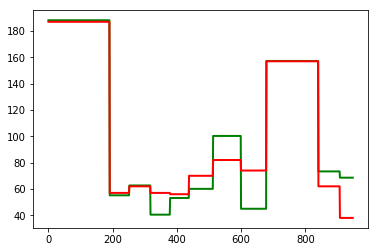

In [172]:
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(j151_labels, color='red', linewidth=2, markersize=12)
plt.show()

Plot predictions on all test data

Note that the plot above contains all 11 segments. According to the plot, and as expected, the network produces the same predicted value for each entry from each segment.

Below is a final scatterplot from the entire test data set.

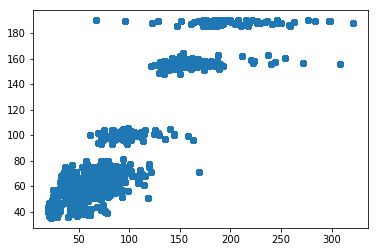

In [154]:
test_predictions = model.predict(test_data.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()